# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2022-12-01 03:35:11--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.250.145.95, 173.194.69.95, 173.194.79.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.250.145.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media.3’

dataset.zip?alt=med 100%[===================>] 378.77M  41.7MB/s    in 9.9s    

2022-12-01 03:35:21 (38.3 MB/s) - ‘dataset.zip?alt=media.3’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

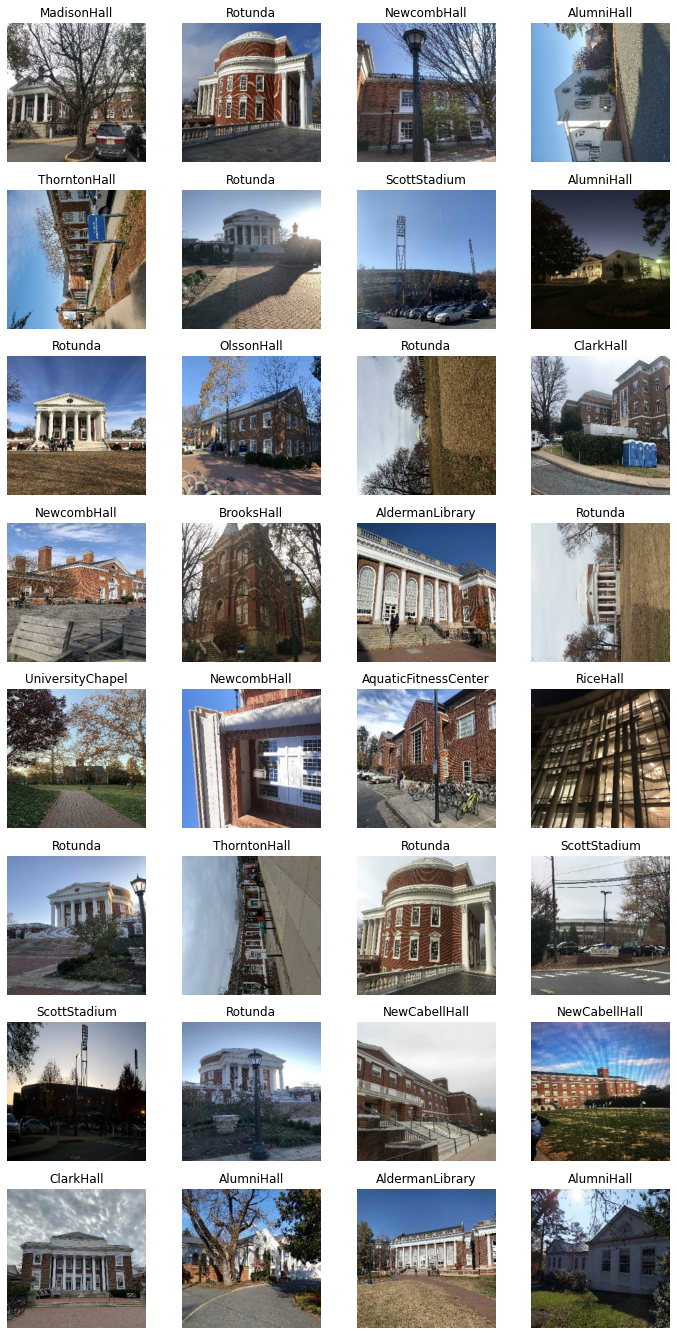

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [7]:
# YOUR CODE STARTS HERE

# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have? 
2.   Why do you decide on a certain number nodes per layer? 
3.   Which activation functions do you choose? 
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [8]:
# Your code here
# myModel = keras.models.Sequential([
#   keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding="valid", activation="relu", input_shape=[img_height,img_width,3]),
#   keras.layers.Lambda(tf.nn.local_response_normalization),
#   keras.layers.MaxPool2D(pool_size=3, strides=2),
#   keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding="same", activation="relu"),
#   keras.layers.Lambda(tf.nn.local_response_normalization),
#   keras.layers.MaxPool2D(pool_size=3, strides=2),
#   keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu"),
#   keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu"),
#   keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
#   keras.layers.Flatten(),
#   keras.layers.Dense(units=128, activation='relu'),
#   keras.layers.Dropout(0.5),
#   keras.layers.Dense(units=64, activation='relu'),
#   keras.layers.Dropout(0.5),
#   keras.layers.Dense(units=18, activation='softmax'),
#           ])

# myModel = keras.models.Sequential([
#     keras.layers.Conv2D(filters=6, kernel_size=5, activation='tanh', input_shape=[img_height, img_width, 3]),
#     keras.layers.AvgPool2D(pool_size=2, strides=2),
#     keras.layers.Conv2D(filters=16, kernel_size=5, activation="tanh"),
#     keras.layers.AvgPool2D(pool_size=2, strides=2),
#     keras.layers.Conv2D(filters=120, kernel_size=5, activation="tanh"),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=100, activation="tanh"),
#     keras.layers.Dense(units=18, activation="softmax"),
# ])

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
      
myModel = keras.models.Sequential()
myModel.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[img_height, img_width, 3]))
myModel.add(keras.layers.BatchNormalization())
myModel.add(keras.layers.Activation("relu"))
myModel.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4: #+ [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    myModel.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
myModel.add(keras.layers.GlobalAvgPool2D())
myModel.add(keras.layers.Flatten())
myModel.add(keras.layers.Dense(64, activation="relu"))
myModel.add(keras.layers.Dense(18, activation="softmax"))


In [9]:
keras.backend.clear_session()

My model has 15 layers. The numbe of nodes starts somewhat arbitrarily, but increases and decreases based on pooling layer size ratios. The last layer has 18 nodes, one for each class. I chose relu for each layer but the last, which is softmax. It has 1360530 total parameters.

In [10]:
myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
myEpochs = 10
myOptimizer = keras.optimizers.Nadam()
myLoss = "sparse_categorical_crossentropy"
myMetrics=["accuracy", "mse"]
myModel.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics)
history = myModel.fit(train_ds, validation_data=validation_ds, epochs = myEpochs)

Epoch 1/10
358/358 [==============================] - 50s 118ms/step - loss: 2.2792 - accuracy: 0.3003 - mse: 130.0529 - val_loss: 6.1453 - val_accuracy: 0.1092 - val_mse: 132.7948
Epoch 2/10
358/358 [==============================] - 43s 120ms/step - loss: 1.5655 - accuracy: 0.5290 - mse: 130.0625 - val_loss: 9.1236 - val_accuracy: 0.1677 - val_mse: 132.8003
Epoch 3/10
358/358 [==============================] - 43s 119ms/step - loss: 1.1411 - accuracy: 0.6681 - mse: 130.0706 - val_loss: 3.8721 - val_accuracy: 0.2695 - val_mse: 132.7827
Epoch 4/10
358/358 [==============================] - 43s 121ms/step - loss: 0.9050 - accuracy: 0.7372 - mse: 130.0757 - val_loss: 3.2075 - val_accuracy: 0.3056 - val_mse: 132.7874
Epoch 5/10
358/358 [==============================] - 43s 119ms/step - loss: 0.7211 - accuracy: 0.7890 - mse: 130.0798 - val_loss: 5.8566 - val_accuracy: 0.0788 - val_mse: 132.7964
Epoch 6/10
358/358 [==============================] - 43s 120ms/step - loss: 0.6186 - accuracy:

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)? 
- Where did it makes mistake most? 
- Which classes can be improved?

In [12]:
# Your evaluation code here
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 10, -0.02, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def plot_learning_curves_acc(Accuracy, val_acc):
  plt.plot(np.arange(len(Accuracy)) + 0.5, Accuracy, "b.-", label="Training Accuracy")
  plt.plot(np.arange(len(val_acc)) + 1, val_acc, "r.-", label="Validation Accuracy")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 10, -0.02, 1])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid(True)

def plot_learning_curves_mse(MSE, val_mse):
  plt.plot(np.arange(len(MSE)) + 0.5, MSE, "b.-", label="Training MSE")
  plt.plot(np.arange(len(val_mse)) + 1, val_mse, "r.-", label="Validation MSE")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 10, -0.02, 1])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("MSE")
  plt.grid(True)

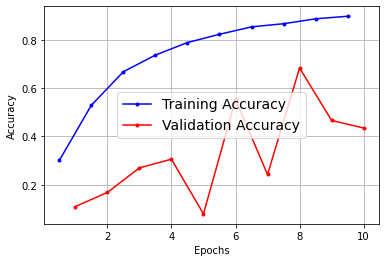

In [13]:
plot_learning_curves_acc(history.history["accuracy"], history.history["val_accuracy"])

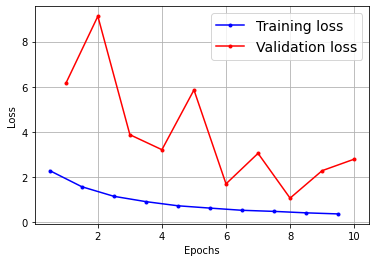

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

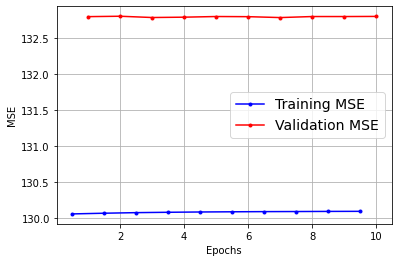

In [15]:
plot_learning_curves_mse(history.history["mse"], history.history["val_mse"])

In [16]:
pred = myModel.predict(validation_ds)

90/90 [==============================] - 5s 49ms/step


In [17]:
y_val = []
y_pred = []
for batch in validation_ds:
  for j in batch[1]:
    y_val.append(int(j))
  b_pred = myModel.predict(batch[0])
  for i in b_pred:
    y_pred.append(np.argmax(i))


1/1 [==============================] - 0s 237ms/step


In [18]:
print(len(y_val))
print(len((y_pred)))

2857
2857


In [19]:
mtx = confusion_matrix(y_val, y_pred)
f_scores = []
for i in mtx:
  print(i)
for i in range(len(mtx)):
  f_scores.append([sum(mtx[i]) - mtx[i][i]])

for i in range(len(mtx)):
  col_sum = 0
  for j in range(len(mtx)):
    col_sum += mtx[j][i]
  f_scores[i].append(col_sum - mtx[i][i])
for k in f_scores:
  print("false negatives:", k[0], ", false positives:", k[1], "total misses:", sum(k))

[29  0  0  0  0  0  2  0  0  2  4  0  0  0 11  2 19 10]
[ 0 43  0  1  0  0  0  0  0 36 26  0  1  0  0  1 39  1]
[ 0 22 25  0  0  0  3  0  0  1  5  1  0  5  0  0 12  8]
[ 0  0  0 49  0  0  1  0  0 11 19  0  0  0  0  6 20 12]
[ 0  0  0  0  0  0  1  0  0 21  3  0  0  0  0  0  1  1]
[ 0  0  0  1  1  7 18  0  0 25  5  0  0  0  3  0 15  5]
[ 0  0  0  1  0  0 65  0  1 20 29  0  1  0  2  1 49  2]
[ 0  0  0  0  0  0  2  5  0  2 14  0  0  1  2  2 36  2]
[ 1 13  0  0  3  0  9  0 21 18 45  2  2  0  2  3 24  1]
[  0   0   0   3   0   0   6   0   0 102  14   0   0   0   0   0   1   4]
[  0   0   0   1   0   0   2   0   0  17 111   0   0   0   0   0   9   1]
[ 1  1  0  0  0  0  6  0  0 15 19 40  0  0 38  0 46  1]
[  0   0   0   0   0   0   2   0   0  17  35   0 103   1   0   0  56   1]
[  0  11   0   1   2   0   3   1   2  24  32   1   1  73   0  10 113  10]
[  0   0   0   1  22   0  11   0   1  33  23   0   0   0 134   1  75   5]
[  2   3   0   0   0   0   0   0   0   1  49   0   1   0   1 120  84  

In [20]:
precision_score(y_val, y_pred, average='weighted')

0.6687229970239917

In [21]:
recall_score(y_val, y_pred, average='weighted')

0.43472173608680437

My architecture is not that good. Its maximum validation accuracy is only about 68%. This is not a passing grade. The training accuracy is fairly good, hitting 90%, but this is to be expected. The most mistakes make were in the "ThorntonHall" class, as indicated by the confusion matrix. It had 646 total misses, most coming from false positives. These classes can definitely improve. The best performing classes were "AcademicVillage" and "AlumniHall" at 54 and 57 classes. Additionally, precision and recall are only 67 and 43 percent.

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [22]:
baseResNetModel = keras.applications.EfficientNetV2M(weights="imagenet", include_top=False, input_shape=[224,224,3])

In [23]:
keras.backend.clear_session()

In [24]:
avg = keras.layers.GlobalAveragePooling2D()(baseResNetModel.output)
flat = keras.layers.Flatten()(avg)
drop = keras.layers.Dropout(0.5)(flat)
output = keras.layers.Dense(18, activation="softmax")(drop)
theirModel = keras.models.Model(inputs=baseResNetModel.input, outputs=output)

In [34]:
print(len(theirModel.layers))

744


My model uses the EfficientNetV2M pre-trained model. I added an average pooling layer, flattened it, added a Droupout layer to reduce overfitting, and created my own Dense top layer with 18 output nodes, one for each class. The model has 53173446 total parameters, and 744 layers.

In [25]:
theirModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [26]:
for layer in baseResNetModel.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
theirModel.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "sparse_categorical_accuracy"])
history = theirModel.fit(train_ds, validation_data=validation_ds, epochs=10, steps_per_epoch=int(0.75 * len(train_ds) / batch_size), validation_steps=int(0.15 * len(train_ds) / batch_size)) #

Epoch 1/10
8/8 [==============================] - 28s 933ms/step - loss: 2.7664 - accuracy: 0.1328 - sparse_categorical_accuracy: 0.1328 - val_loss: 2.2498 - val_accuracy: 0.3750 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 2s 320ms/step - loss: 2.1442 - accuracy: 0.4102 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.9599 - val_accuracy: 0.5312 - val_sparse_categorical_accuracy: 0.5312
Epoch 3/10
8/8 [==============================] - 2s 324ms/step - loss: 1.8883 - accuracy: 0.4883 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.8118 - val_accuracy: 0.4688 - val_sparse_categorical_accuracy: 0.4688
Epoch 4/10
8/8 [==============================] - 2s 324ms/step - loss: 2.0642 - accuracy: 0.4883 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.4803 - val_accuracy: 0.5938 - val_sparse_categorical_accuracy: 0.5938
Epoch 5/10
8/8 [==============================] - 2s 323ms/step - loss: 1.7106 - accuracy: 0.5156 - sparse_categorical_

In [27]:
for layer in baseResNetModel.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.03, momentum=0.9, nesterov=True, decay=0.001)
theirModel.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "sparse_categorical_accuracy"])
history = theirModel.fit(train_ds, steps_per_epoch=int(0.75 * len(train_ds) / batch_size), validation_data=validation_ds, validation_steps=int(0.15 * len(train_ds) / batch_size), epochs=40)

Epoch 1/40
8/8 [==============================] - 39s 1s/step - loss: 2.5124 - accuracy: 0.3164 - sparse_categorical_accuracy: 0.3164 - val_loss: 6.7197 - val_accuracy: 0.2188 - val_sparse_categorical_accuracy: 0.2188
Epoch 2/40
8/8 [==============================] - 7s 886ms/step - loss: 1.7310 - accuracy: 0.5234 - sparse_categorical_accuracy: 0.5234 - val_loss: 3.4937 - val_accuracy: 0.3125 - val_sparse_categorical_accuracy: 0.3125
Epoch 3/40
8/8 [==============================] - 7s 896ms/step - loss: 1.6590 - accuracy: 0.5586 - sparse_categorical_accuracy: 0.5586 - val_loss: 2.5907 - val_accuracy: 0.4688 - val_sparse_categorical_accuracy: 0.4688
Epoch 4/40
8/8 [==============================] - 7s 896ms/step - loss: 1.4635 - accuracy: 0.6133 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.8957 - val_accuracy: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/40
8/8 [==============================] - 7s 887ms/step - loss: 1.2584 - accuracy: 0.6523 - sparse_categorical_acc

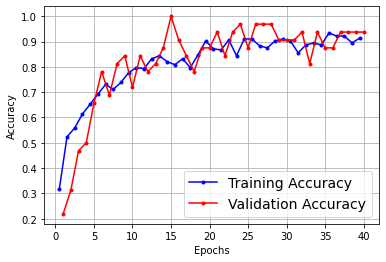

In [28]:
plot_learning_curves_acc(history.history["accuracy"], history.history["val_accuracy"])

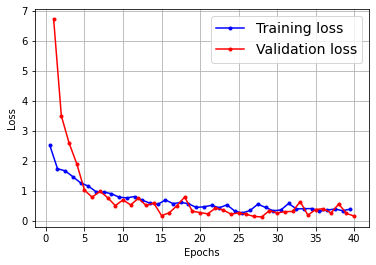

In [29]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [30]:
pred = theirModel.predict(validation_ds)

90/90 [==============================] - 25s 222ms/step


In [31]:
y_val = []
y_pred = []
for batch in validation_ds:
  for j in batch[1]:
    y_val.append(int(j))
  b_pred = theirModel.predict(batch[0])
  for i in b_pred:
    y_pred.append(np.argmax(i))

1/1 [==============================] - 4s 4s/step


In [32]:
mtx = confusion_matrix(y_val, y_pred)
f_scores = []
for i in mtx:
  print(i)
for i in range(len(mtx)):
  f_scores.append([sum(mtx[i]) - mtx[i][i]])

for i in range(len(mtx)):
  col_sum = 0
  for j in range(len(mtx)):
    col_sum += mtx[j][i]
  f_scores[i].append(col_sum - mtx[i][i])
for k in f_scores:
  print("false negatives:", k[0], ", false positives:", k[1], "total misses:", sum(k))

[69  0  0  1  0  0  0  0  1  0  0  1  0  0  6  0  1  0]
[  0 145   0   0   0   0   1   0   0   0   0   1   0   0   0   1   0   0]
[ 0  1 75  0  0  0  1  0  0  0  0  0  0  0  0  1  1  3]
[  0   0   0 105   0   0   0   0   0   0   4   1   2   1   0   2   2   1]
[ 0  0  0  0 20  1  0  0  0  0  4  0  0  0  0  0  2  0]
[ 0  0  0  1  0 74  0  0  2  0  0  0  0  0  1  0  0  2]
[  0   1   0   0   0   0 158   0   3   0   0   1   1   0   1   1   5   0]
[ 0  1  0  0  0  0  0 61  1  0  1  0  0  0  2  0  0  0]
[  0   0   0   0   0   0   0   0 140   0   0   1   3   0   0   0   0   0]
[  0   0   0   3   0   0   0   0   2 109   6   1   3   4   0   0   2   0]
[  0   0   0   0   0   0   0   0   0   4 135   0   1   0   1   0   0   0]
[  0   1   0   0   0   0   1   1   1   2   2 156   0   1   1   0   1   0]
[  0   0   0   0   0   0   0   1   1   0   0   0 211   1   0   0   1   0]
[  0   0   0   1   0   0   0   0   0   0   0   1   1 279   0   1   0   1]
[ 11   0   0   1   0   0   1   1   1   0   0   4   0  

In [33]:
print(precision_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average='weighted'))

0.9348731118820739
0.9331466573328666


Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall? 
- In which class it improve the accuracy from the above model? 
- Which class still has low performance? 

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

This pretrained network did much better. The accuracy for both train and validation sets was much higher, peaking at .9336 and 1 respectively, with validation stabilizing at .9375 for the last 4 epochs (multiple epochs over 94%). The confusion matrix reports much better numbers. Overall the total misses are down significantly, and precision and recall are both at about 93%, a great improvement from 67% and 43%. The accuracy was most improved from class "ThorntonHall," because in my first model, there were over 600 total misses, and that number is greatly reduced to 44 total misses. However, this class still had the most total misses.

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

My network was much worse than the pre-trained one. If I was able to run more epochs in my model, the disparity might have been less, but probably still quite large. My model is based of of ResNet50, which uses skip layers depending on the filter size. The pretrained model I used is EfficientNetV2M, which has many more layers overall. However, there are similarities between the two because I added a drop layer before the final Dense layer, meaning the two models have the same last 2 layers. I learned a lot from implementing both models, but probably more from making my own model. Adding each layer manually gives a lot more insight into what is going on, so I can understand more what each layer is accomplishing. The pretrained model was frustrating because I spent a lot of time trying to fix it when I was getting abysmal numbers, but after a while I just decided to change which model I was using and I got substantially better numbers. Once it did work though it was very satisfying.